# Assessment of drift in Cycle 4.
This notebook calculates global averages of T, S, and BGC state variables in the uppermost layer, upper 100 m, and throughout the depth.

In [1]:
import climtas.nci
import cosima_cookbook as cc
import numpy as np
import scipy
#climtas.nci.Client(malloc_trim_threshold='64kib')
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
client = Client()
client

2022-12-14 14:59:54,778 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/66798807.gadi-pbs/dask-worker-space/worker-shi3xqps', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36539,Workers: 2
Dashboard: /proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:37029,Total threads: 1
Dashboard: /proxy/43247/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:45727,


In [2]:
session = cc.database.create_session()

### What is the name of your ACCESS-OM2 experiment?

In [3]:
ename = '01deg_jra55v140_iaf_cycle4'

In [4]:
datadir = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4/'

In [5]:
def preproc(ds):
    return ds.groupby('time.year').mean()

In [6]:
area = xr.open_dataset(datadir + '/output990/ocean/ocean-2d-area_t.nc').drop_dims('time').area_t
area

<xarray.DataArray 'area_t' (yt_ocean: 2700, xt_ocean: 3600)>
[9720000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Attributes:
    long_name:     tracer cell area
    units:         m^2
    valid_range:   [0.e+00 1.e+15]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t

In [7]:
files = sorted(glob(datadir + '/output*/ocean/ocean-3d-dzt-1-monthly-mean-*.nc'))
dzt = xr.open_mfdataset(files, preprocess=preproc,parallel=True).dzt
dzt

<xarray.DataArray 'dzt' (year: 61, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<concatenate, shape=(61, 75, 2700, 3600), dtype=float32, chunksize=(1, 75, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * year      (year) int64 1958 1959 1960 1961 1962 ... 2014 2015 2016 2017 2018
Attributes:
    long_name:      t-cell thickness
    units:          m
    valid_range:    [-1.e+01  1.e+05]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  cell_thickness

In [8]:
vol1y = (dzt*area)

In [9]:
vname = ['temp', 'salt', 'o2', 'adic', 'dic', 'alk', 'caco3', 'det', 'fe', 'phy', 'zoo', 'no3']

In [10]:
fukasa = [1,100,10000]

In [11]:
for i in range(np.size(vname)):
    if vname[i] in ['temp','salt']:
        files = sorted(glob(datadir + '/output*/ocean/ocean-3d-'+vname[i]+'-1-monthly-mean-*.nc'))
    else:
        files = sorted(glob(datadir + '/output*/ocean/oceanbgc-3d-'+vname[i]+'-1-monthly-mean-*.nc'))
    data1y = xr.open_mfdataset(files, preprocess=preproc,parallel=True)[vname[i]]
    for j in range(np.size(fukasa)):
        dataz = data1y.sel(st_ocean=slice(None,fukasa[j]))
        volz = vol1y.sel(st_ocean=slice(None,fukasa[j]))
        ts1y = (dataz*volz).sum(('st_ocean','yt_ocean','xt_ocean'))/volz.sum(('st_ocean','yt_ocean','xt_ocean'))
        ts1y.load().to_netcdf('/g/data/v45/hh0162/projects/notebook_access-om2/nc/ACCESS-WOMBAT_01deg_BGC_validation-'+vname[i]+'-upper-'+str(fukasa[j])+'.nc')


2022-12-14 15:01:23,448 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.15 GiB -- Worker memory limit: 4.50 GiB
2022-12-14 15:01:23,547 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.18 GiB -- Worker memory limit: 4.50 GiB
2022-12-14 15:01:23,572 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

KilledWorker: Attempted to run task ('open_dataset-05003a87aef12742998616e5de94f5c8dzt-a1fda4fdbac823dabecf2d807c69d5d6', 0, 0, 0, 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:38303. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [52]:
ts1y.load()

2022-12-14 14:10:45,542 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.26 GiB -- Worker memory limit: 4.50 GiB
2022-12-14 14:10:45,609 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.33 GiB -- Worker memory limit: 4.50 GiB
2022-12-14 14:10:45,711 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

KilledWorker: Attempted to run task ('open_dataset-05003a87aef12742998616e5de94f5c8dzt-a1fda4fdbac823dabecf2d807c69d5d6', 0, 0, 0, 0) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:33341. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

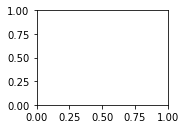

In [24]:
fig = plt.figure(figsize=(8,8))
for i in range(np.size(vname)):
    for j in range(np.size(fukasa)):
        ts1y = xr.open_dataset('/g/data/v45/hh0162/projects/notebook_access-om2/nc/ACCESS-WOMBAT_01deg_BGC_validation-'+vname[i]+'-upper-'+str(fukasa[j])+'.nc')
        plt.subplot(4,3,i+1)
        ts1y.plot(label=fukasa[j])
plt.legend()
plt.tight_layout()

In [32]:
dzt.dzt

<xarray.DataArray 'dzt' (year: 61, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<concatenate, shape=(61, 75, 2700, 3600), dtype=float32, chunksize=(1, 75, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * year      (year) int64 1958 1959 1960 1961 1962 ... 2014 2015 2016 2017 2018
Attributes:
    long_name:      t-cell thickness
    units:          m
    valid_range:    [-1.e+01  1.e+05]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  cell_thickness

### Load the grid cell area info (needed for spatial averaging because grid cells have different sizes)

In [4]:
area = cc.querying.getvar(ename, 'area_t', session, n=1)
area

2022-12-13 15:43:05,407 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-12-13 15:43:05,407 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-12-13 15:43:05,407 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-12-13 15:43:05,407 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/distributed/nanny.py", line 981, in _run
    asyncio.run(run())
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/asyncio/runners.py", line 44, in run
    return loop.run_until_complete(main)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/asyncio/base_events.py", line 634, in run_until_complete
  

KeyboardInterrupt: 

In [ ]:
dzt = cc.querying.getvar(ename, 'dzt', session, ncfile='%monthly%')
dzt

### Volume of grid cells (area multiplied by thickness)
do not add .load() or else the kernel will die.

In [6]:
vol = (dzt*area)
vol

<xarray.DataArray (time: 732, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<mul, shape=(732, 75, 2700, 3600), dtype=float32, chunksize=(1, 19, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 1958-01-16T12:00:00 ... 2018-12-16T12:00:00

### What are the names of the variables you want to analyse? The list is below:
http://cosima.org.au/index.php/2020/07/29/data-available-0-1-1958-2018-access-om2-iaf-run/

In [10]:
vname = ['temp', 'salt', 'o2', 'adic', 'dic', 'alk', 'caco3', 'det', 'fe', 'phy', 'zoo', 'no3']

### Specify the depth limits for vertical averaging
In practice, 10000 = None

In [11]:
fukasa = [1,100,10000]

### Do the loop to produce global average
Save the 61-year time series, so that plotting can be done separately.

In [ ]:
vol1y = vol.groupby('time.year').mean().load()


In [ ]:
vol1y = vol.groupby('time.year').mean().load()
for i in range(np.size(vname)):
    data = cc.querying.getvar(ename, vname[i], session, ncfile='%monthly%')
    data1y = data.groupby('time.year').mean().load()
    for j in range(np.size(fukasa)):
        dataz = data1y.sel(st_ocean=slice(None,fukasa[j]))
        volz = vol1y.sel(st_ocean=slice(None,fukasa[j]))
        ts1y = (dataz*volz).sum(('st_ocean','yt_ocean','xt_ocean'))/volz.sum(('st_ocean','yt_ocean','xt_ocean'))
        ts1y.to_netcdf('/g/data/v45/hh0162/projects/notebook_access-om2/nc/ACCESS-WOMBAT_01deg_BGC_validation-'+vname[i]+'-upper-'+str(fukasa[j])+'.nc')


### Plot the 61-year surface, upper-100m, whole-depth time series